In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


### Seq from real

In [2]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_173',
 '/media/beans/ssd/bespoke_logging/run_174',
 '/media/beans/ssd/bespoke_logging/run_175',
 '/media/beans/ssd/bespoke_logging/run_176',
 '/media/beans/ssd/bespoke_logging/run_176a',
 '/media/beans/ssd/bespoke_logging/run_176b',
 '/media/beans/ssd/bespoke_logging/run_176c',
 '/media/beans/ssd/bespoke_logging/run_176d',
 '/media/beans/ssd/bespoke_logging/run_176e',
 '/media/beans/ssd/bespoke_logging/run_176f',
 '/media/beans/ssd/bespoke_logging/run_176g',
 '/media/beans/ssd/bespoke_logging/run_177',
 '/media/beans/ssd/bespoke_logging/run_178',
 '/media/beans/ssd/bespoke_logging/run_178a',
 '/media/beans/ssd/bespoke_logging/run_178b',
 '/media/beans/ssd/bespoke_logging/run_179',
 '/media/beans/ssd/bespoke_logging/run_179a',
 '/media/beans/ssd/bespoke_logging/run_180',
 '/media/beans/ssd/bespoke_logging/run_181',
 '/media/beans/ssd/bespoke_logging/run_182',
 '/media/beans/ssd/bespoke_logging/run_183',
 '/media/beans/ssd/bespoke_logging/run_184',


In [4]:
#run_id = "run_382" # out sabq to pow to grade
#run_id = "run_383" # back from grade, 214, madrona
run_id = "run_392"

run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
model_stem = "6.28_avg"

In [5]:
aux = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/aux/*"))]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))]).astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape

(25680, 100, 640, 3)

In [6]:
commanded_torque = car_state[:, 7]

array([1.6000e+01, 1.2000e+01, 2.8000e+01, 2.2000e+01, 6.1000e+01,
       7.0000e+01, 1.9560e+03, 1.8794e+04, 4.4980e+03, 2.2300e+02])

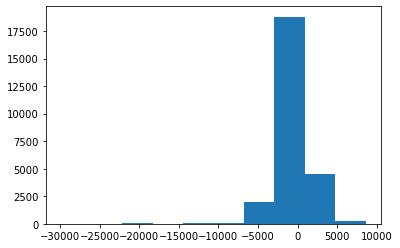

In [7]:
plt.hist(commanded_torque)[0]

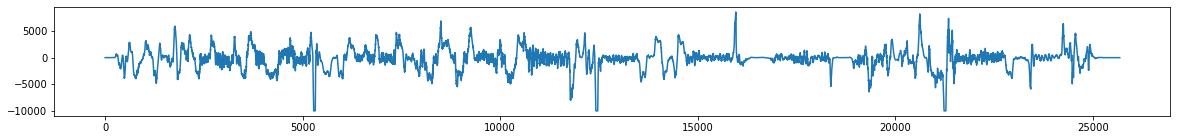

In [8]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

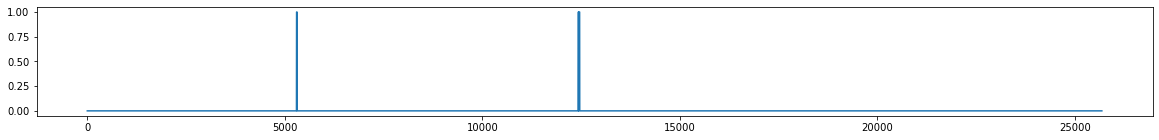

In [9]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([1145.,  303.,  519., 1829., 9574., 9867., 1222.,  347.,  257.,
        617.])

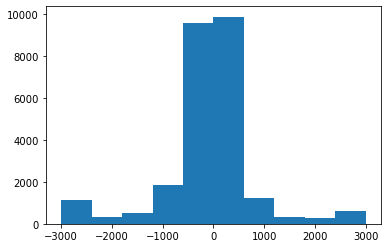

In [10]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -3000, 3000))[0]

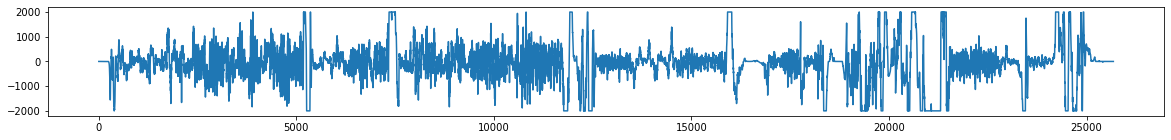

In [11]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -2000, 2000))

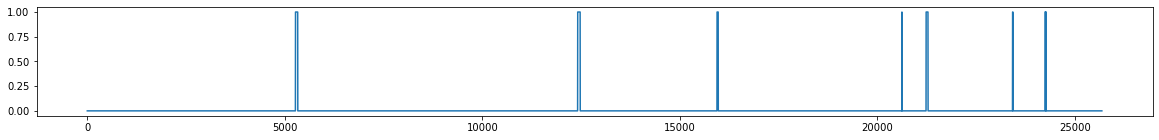

In [12]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

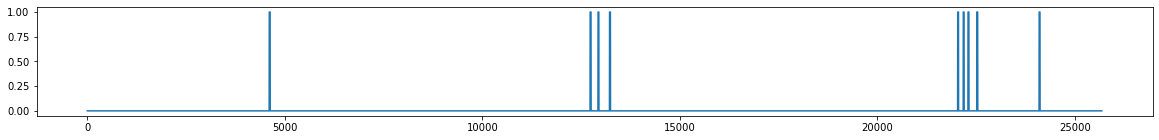

In [14]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

In [15]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

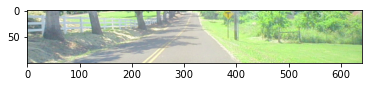

In [16]:
plt.imshow(img[15_750])

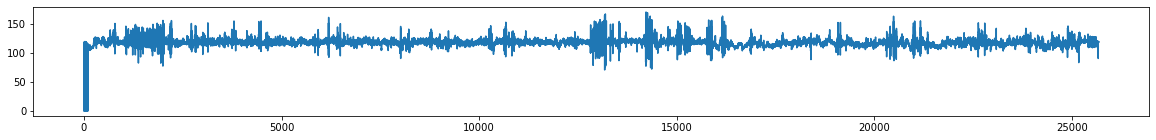

In [17]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([3.2000e+01, 2.9000e+01, 2.4461e+04, 0.0000e+00, 1.0620e+03,
        4.0000e+01, 0.0000e+00, 2.6000e+01, 1.2000e+01, 0.0000e+00,
        1.0000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([15. , 15.7, 16.4, 17.1, 17.8, 18.5, 19.2, 19.9, 20.6, 21.3, 22. ,
        22.7, 23.4, 24.1, 24.8, 25.5, 26.2, 26.9, 27.6, 28.3, 29. ],
       dtype=float16),
 <BarContainer object of 20 artists>)

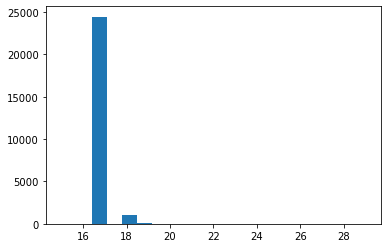

In [18]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [19]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((25679, 100, 640, 3), (25679, 5), (25679, 12), (25679,))

(array([   97.,   849.,  1719.,  3923., 15543.,  1693.,  1344.,   373.,
           91.,    47.]),
 array([-6344. , -4864. , -3380. , -1899. ,  -417.5,  1064. ,  2546. ,
         4028. ,  5508. ,  6992. ,  8472. ], dtype=float16),
 <BarContainer object of 10 artists>)

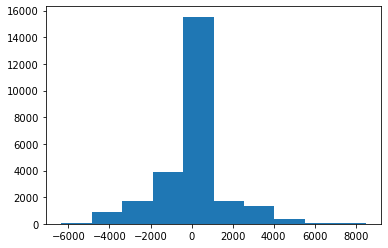

In [20]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([5.0000e+00, 2.9000e+01, 1.6400e+02, 1.1080e+03, 1.0139e+04,
        1.2851e+04, 1.1670e+03, 1.7000e+02, 4.1000e+01, 4.0000e+00]),
 array([-514. , -411.2, -308.5, -205.6, -102.8,    0. ,  102.8,  205.6,
         308.5,  411.2,  514. ], dtype=float16),
 <BarContainer object of 10 artists>)

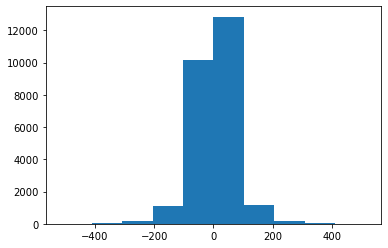

In [21]:
plt.hist(torque[1:]-torque[:-1])

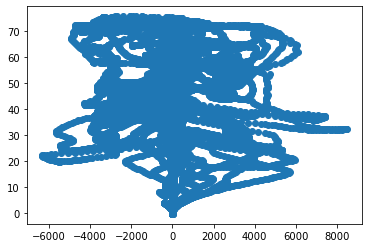

In [22]:
plt.scatter(torque, aux[:,2])

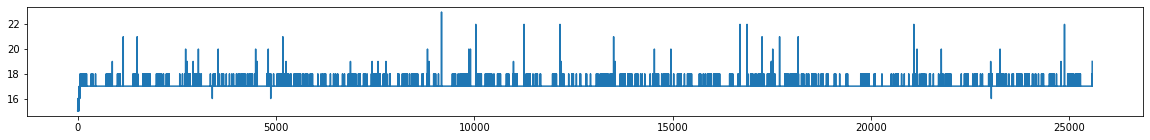

In [23]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

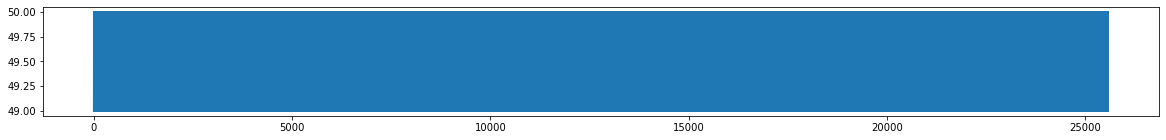

In [24]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

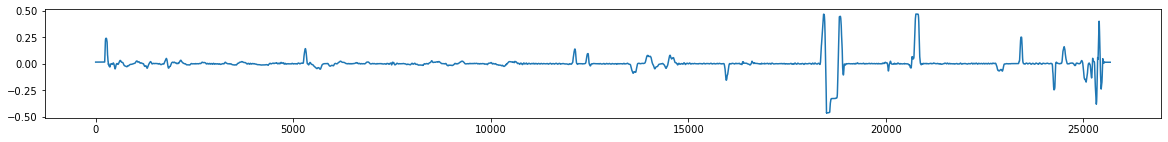

In [25]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [26]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

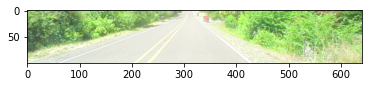

In [27]:
plt.imshow(img[6644])

(array([  109.,   201.,   100.,   259., 17309.,  7019.,   258.,   151.,
           68.,   205.]),
 array([-0.4631 , -0.37   , -0.2769 , -0.1838 , -0.09076,  0.00232,
         0.0954 ,  0.1885 ,  0.2815 ,  0.3748 ,  0.4678 ], dtype=float16),
 <BarContainer object of 10 artists>)

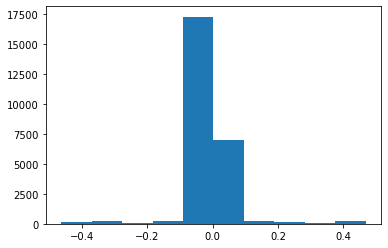

In [28]:
plt.hist(steer_angle)

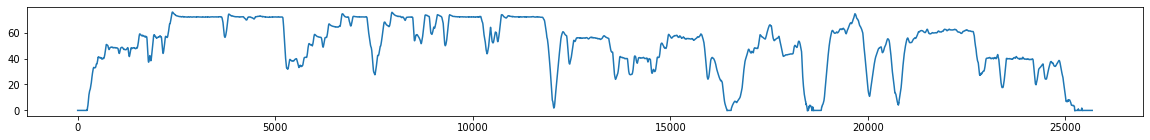

In [29]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([1780.,  523.,  485., 1092., 1647., 3565., 2608., 5061., 2535.,
        6383.]),
 array([-0.3423,  7.273 , 14.89  , 22.5   , 30.12  , 37.75  , 45.34  ,
        52.97  , 60.6   , 68.2   , 75.8   ], dtype=float16),
 <BarContainer object of 10 artists>)

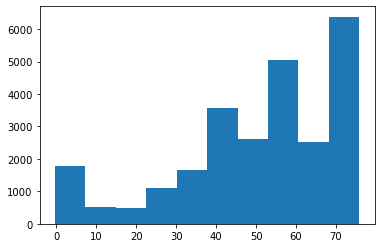

In [30]:
# speed
plt.hist(aux[:,2])

In [31]:
kph_to_mph = lambda x : x / 1.609

In [32]:
max_speed_lookup_rollout = [
    (.157, 16.6),
    (.11, 20),
    (.071, 25.5),
    (.052, 28.7),
    (.037, 34.1),
    (.027, 39.3),
    (.021, 44.7),
    (.018, 50), # this is a guess, TODO update this
]
max_speed_bps_rollout = [x[0] for x in max_speed_lookup_rollout][::-1]
max_speed_vals_rollout = [x[1] for x in max_speed_lookup_rollout][::-1]

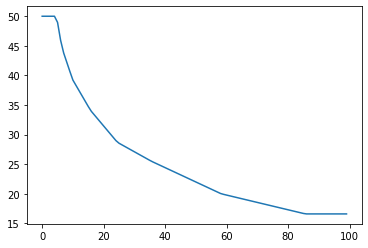

In [33]:
plt.plot([np.interp(x, max_speed_bps_rollout, max_speed_vals_rollout) for x in np.linspace(.01, .18, 100)])

In [34]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=abs(steer_angle), width=600, height=600)
fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, .2])
fig.show()

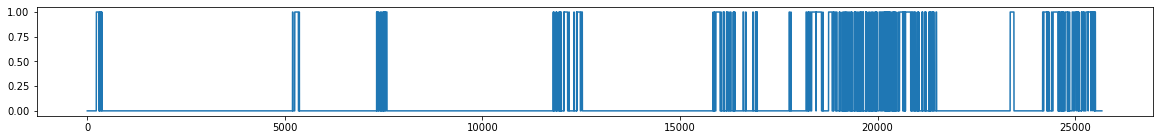

In [35]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([  430757.,  2845499.,  5572749.,  7355563., 10314041., 11623979.,
        10254410., 11814718., 19174537.,  2789747.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

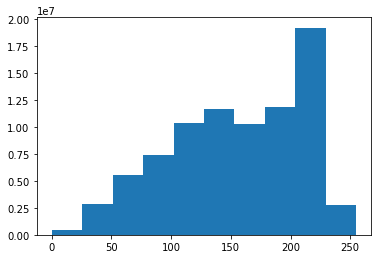

In [36]:
plt.hist(img[::20,:,:,2].flatten())

In [37]:
img.mean()

175.45302804354563

In [38]:
make_vid(run_id, model_stem, img, aux)

(25679, 22) (25679, 1, 13, 80) (25679, 1, 13, 80)
Made vid!


In [ ]:
preds_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = get_viz_rollout(model_stem, img, aux)
preds_all.shape

In [ ]:
speeds = aux[:,2]
wp_angles = gather_preds(preds_all, speeds)

In [ ]:
b, e = 0, -1
plt.figure(figsize=(20,5))
plt.plot(steer_angle[b:e])
plt.plot(np.array(wp_angles[b:e]*-1)) 

In [ ]:
speeds_mps = kph_to_mps(aux[:,2])
trajs = torch.FloatTensor(preds_all[:,:N_WPS_TO_USE]).to('cuda')
traj_xs, traj_ys = get_trajs_world_space(trajs, speeds_mps, tire_angle_rad, CRV_WHEELBASE)
traj_xs.shape

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=traj_xs[::8].cpu().numpy().flatten(), y=traj_ys[::8].cpu().numpy().flatten(), width=900, height=900)
fig.update_yaxes(range=[0, 1500])
fig.update_xaxes(range=[-1500, 0])
fig.show()

In [ ]:
temporal_error = get_temporal_error(traj_xs, traj_ys, speeds_mps)
temporal_error_sqrt = np.sqrt(temporal_error.cpu())

In [ ]:
_make_vid(model_stem, run_id, preds_all, img, 
             cnn_grads, cnn_activations, rnn_grads, rnn_activations, temporal_error_sqrt)

In [ ]:
preds_all.shape